# AIxロボティクスによる創造的タスクの実現

本課題に関して，「強化学習による倒立振子システムの制御」を目的として検討を行う．倒立振子システムは，台車に制御力を加えて棒を直立させることを目的とする比較的シンプルなシステムであるが，制御を行わない場合に外乱・初期状態により系が発散する（棒が倒れてしまう）不安定系であるという特徴がある．不安定系の制御は一般に安定系よりも難しいが，うまく制御することができれば，少ない制御力で速い応答を得ることができる．
類似のシステムは，人間の二足歩行，ロケットや人工衛星の姿勢制御などにみられ，多くの設計事例がある．

シミュレータとしては，Gymnasiumを用い，PID制御との結果の比較を行う．

強化学習には，強化学習用フレームワークであるAgileRL (https://www.agilerl.com/) を使用する．AgileRLは高速であることをうたっており，主要なアルゴリズムをサポートしている．
コードについては，倒立振子システム用のサンプル(https://docs.agilerl.com/en/latest/tutorials/gymnasium/agilerl_rainbow_dqn_tutorial.html) を参考とし，一部改修して用いた．








# 実行環境の整備

Google **ColabおよびローカルUbuntu環境で実行を行った．まず，pipパッケージマネージャを用いて，AgileRLをインストールする．Colab環境では，PyTorchが一部参照エラーとなったので，バージョンを指定した．**


In [2]:
!pip install agilerl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:

In [2]:
#!pip install transformers==4.50.0
!pip install torch==2.6.0
#!pip install torchvision==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
agilerl 2.3.0 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.


必要なパッケージを読み込む．



In [1]:
import os
import imageio
import gymnasium as gym
import numpy as np
import torch
from agilerl.algorithms.dqn_rainbow import RainbowDQN
from agilerl.components.replay_buffer import (
    MultiStepReplayBuffer,
    PrioritizedReplayBuffer,
)
from agilerl.training.train_off_policy import train_off_policy
from agilerl.utils.utils import make_vect_envs
from tqdm import trange

[2025-07-21 04:01:18,207] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-07-21 04:01:21,477] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


ハイパーパラメータ（の初期値）を設定する．バッチサイズは64とする．

In [2]:
# Initial hyperparameters
INIT_HP = {
    "BATCH_SIZE": 64,  # Batch size
    "LR": 0.0001,  # Learning rate
    "GAMMA": 0.99,  # Discount factor
    "MEMORY_SIZE": 100_000,  # Max memory buffer size
    "LEARN_STEP": 1,  # Learning frequency
    "N_STEP": 3,  # Step number to calculate td error
    "PER": True,  # Use prioritized experience replay buffer
    "ALPHA": 0.6,  # Prioritized replay buffer parameter
    "BETA": 0.4,  # Importance sampling coefficient
    "TAU": 0.001,  # For soft update of target parameters
    "PRIOR_EPS": 0.000001,  # Minimum priority for sampling
    "NUM_ATOMS": 51,  # Unit number of support
    "V_MIN": -200.0,  # Minimum value of support
    "V_MAX": 200.0,  # Maximum value of support
    "NOISY": True,  # Add noise directly to the weights of the network
    "LEARNING_DELAY": 1000,  # Steps before starting learning
    "TARGET_SCORE": 200.0,  # Target score that will beat the environment
    "MAX_STEPS": 200000,  # Maximum number of steps an agent takes in an environment
    "EVO_STEPS": 10000,  # Evolution frequency
    "EVAL_STEPS": None,  # Number of evaluation steps per episode
    "EVAL_LOOP": 1,  # Number of evaluation episodes
}

シミュレータ環境にはGymnasiumを用い，倒立振子システムモデル"CartPole-v1"を用いる．

強化学習のアルゴリズムには，Rainbow-DQN (https://arxiv.org/abs/1710.02298) を用いる．

Rainbow DQNは深層学習に基づく強化学習として一般的に用いられるDQN (Deep Q-Network) を拡張したもので，高い性能を達成するために複数の改良と技術を統合している．

これらの改良には以下が含まれる：

- ダブルDQN（DDQN）： 2つのネットワークを用いてQ学習対象の行動の選択と評価を切り離すことで、Q値の過大評価バイアスに対処する。

- 優先経験再生： リプレイバッファから一様にサンプリングするのではなく、時間差（TD）誤差の大きさに基づいて、より重要な遷移をより頻繁にサンプリングする。

- トーナメントネットワーク： Q-ネットワークを2つの別々のストリームに分割する。1つは状態値関数を推定するためのストリーム、もう1つは各行動の利点を推定するためのストリームです。それらを組み合わせてQ値を生成する。

- 多段階学習（n段階リターン）： 学習に即時の報酬だけを使用する代わりに、将来の報酬のシーケンスを考慮する多段階リターンを使用する。

- 分布型RL: 将来の累積報酬の期待値を推定する代わりに、将来の累積報酬の分布全体を予測する。

- ノイジーネット(Noisy Nets): ネットワークの重みに直接ノイズを加え、ε-greedy探索を必要とせずに環境を探索する方法を提供する。

- カテゴリーDQN (C51)： 分布型RLの特殊な形態で、可能な将来の累積報酬の連続的な範囲が、固定のカテゴリセットに離散化される。

深層学習に関しては，隠れ層2層（ノード数：64）のシンプルなMLPをエンコーダおよびヘッダに用いる．


In [3]:
# Environment setup
num_envs = 16
env = make_vect_envs("CartPole-v1", num_envs=num_envs)  # Create environment

observation_space = env.single_observation_space
action_space = env.single_action_space

# Set-up the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the network configuration of a simple mlp with two hidden layers, each with 64 nodes
net_config = {
    "encoder_config": {"hidden_size": [64, 64]},  # Encoder hidden size
    "head_config": {"hidden_size": [64, 64]}  # Head hidden size
}

# Define a Rainbow-DQN agent
rainbow_dqn = RainbowDQN(
    observation_space=observation_space,
    action_space=action_space,
    net_config=net_config,
    batch_size=INIT_HP["BATCH_SIZE"],
    lr=INIT_HP["LR"],
    learn_step=INIT_HP["LEARN_STEP"],
    gamma=INIT_HP["GAMMA"],
    tau=INIT_HP["TAU"],
    beta=INIT_HP["BETA"],
    n_step=INIT_HP["N_STEP"],
    device=device,
)


memory = PrioritizedReplayBuffer(
    max_size=INIT_HP["MEMORY_SIZE"],
    alpha=INIT_HP["ALPHA"],
    device=device,
)
n_step_memory = MultiStepReplayBuffer(
    max_size=INIT_HP["MEMORY_SIZE"],
    n_step=INIT_HP["N_STEP"],
    gamma=INIT_HP["GAMMA"],
    device=device,
)


倒立振子システムの制御に関する学習を行う．停止条件は，棒の角度またはカートの位置が制限値（±12度, ±2.4）に達するか，最大ステップ(500)に達した時とする．フレーム速度は50fps，時間刻みは 0.02sである．

試行回数は20万ステップとする．このケースでは，強化学習の報酬はステップであり，1ステップ毎に報酬1が得られる．

In [4]:
# Define parameters per and n_step
trained_pop, pop_fitnesses = train_off_policy(
    env=env,
    env_name="CartPole-v1",
    algo="RainbowDQN",
    pop=[rainbow_dqn],
    memory=memory,
    n_step_memory=n_step_memory,
    INIT_HP=INIT_HP,
    max_steps=INIT_HP["MAX_STEPS"],
    evo_steps=INIT_HP["EVO_STEPS"],
    eval_steps=INIT_HP["EVAL_STEPS"],
    eval_loop=INIT_HP["EVAL_LOOP"],
    learning_delay=INIT_HP["LEARNING_DELAY"],
    target=INIT_HP["TARGET_SCORE"],
    n_step=True,
    per=True,
    tournament=None,
    mutation=None,
    wb=False,  # Boolean flag to record run with Weights & Biases
    checkpoint=INIT_HP["MAX_STEPS"],
    checkpoint_path="RainbowDQN.pt",
)



Training...


  5%|5         | 10000/200000 [  03:22<1:04:14, 49.30step/s]


                --- Global Steps 10000 ---
                Fitness:		['27.31']
                Score:		[22.294536817102138]
                5 fitness avgs:	['27.31']
                10 score avgs:	['23.70']
                Agents:		[0]
                Steps:		[10000]
                Mutations:		[None]


 10%|#         | 20000/200000 [  07:06<1:04:26, 46.55step/s]


                --- Global Steps 20000 ---
                Fitness:		['8.94']
                Score:		[20.6369710467706]
                5 fitness avgs:	['18.12']
                10 score avgs:	['13.40']
                Agents:		[0]
                Steps:		[20000]
                Mutations:		[None]


 15%|#5        | 30000/200000 [  10:44<1:01:20, 46.19step/s]


                --- Global Steps 30000 ---
                Fitness:		['9.38']
                Score:		[19.157464212678935]
                5 fitness avgs:	['15.21']
                10 score avgs:	['20.50']
                Agents:		[0]
                Steps:		[30000]
                Mutations:		[None]


 20%|##        | 40000/200000 [  14:22<  57:51, 46.09step/s]


                --- Global Steps 40000 ---
                Fitness:		['9.31']
                Score:		[20.042643923240938]
                5 fitness avgs:	['13.73']
                10 score avgs:	['25.40']
                Agents:		[0]
                Steps:		[40000]
                Mutations:		[None]


 25%|##5       | 50000/200000 [  17:58<  54:11, 46.13step/s]


                --- Global Steps 50000 ---
                Fitness:		['9.31']
                Score:		[18.50300601202405]
                5 fitness avgs:	['12.85']
                10 score avgs:	['19.70']
                Agents:		[0]
                Steps:		[50000]
                Mutations:		[None]


 30%|###       | 60000/200000 [  21:34<  50:28, 46.22step/s]


                --- Global Steps 60000 ---
                Fitness:		['9.25']
                Score:		[17.322701688555348]
                5 fitness avgs:	['9.24']
                10 score avgs:	['18.40']
                Agents:		[0]
                Steps:		[60000]
                Mutations:		[None]


 35%|###5      | 70000/200000 [  25:09<  46:46, 46.31step/s]


                --- Global Steps 70000 ---
                Fitness:		['9.19']
                Score:		[19.457556935817806]
                5 fitness avgs:	['9.29']
                10 score avgs:	['17.50']
                Agents:		[0]
                Steps:		[70000]
                Mutations:		[None]


 40%|####      | 80000/200000 [  28:43<  43:05, 46.40step/s]


                --- Global Steps 80000 ---
                Fitness:		['12.31']
                Score:		[16.60427807486631]
                5 fitness avgs:	['9.88']
                10 score avgs:	['11.80']
                Agents:		[0]
                Steps:		[80000]
                Mutations:		[None]


 45%|####5     | 90000/200000 [  32:24<  39:49, 46.04step/s]


                --- Global Steps 90000 ---
                Fitness:		['40.38']
                Score:		[27.795665634674922]
                5 fitness avgs:	['16.09']
                10 score avgs:	['34.00']
                Agents:		[0]
                Steps:		[90000]
                Mutations:		[None]


 50%|#####     | 100000/200000 [  36:05<  36:21, 45.84step/s]


                --- Global Steps 100000 ---
                Fitness:		['16.31']
                Score:		[45.63316582914573]
                5 fitness avgs:	['17.49']
                10 score avgs:	['92.80']
                Agents:		[0]
                Steps:		[100000]
                Mutations:		[None]


 55%|#####5    | 110000/200000 [  39:44<  32:46, 45.76step/s]


                --- Global Steps 110000 ---
                Fitness:		['10.44']
                Score:		[48.0]
                5 fitness avgs:	['17.73']
                10 score avgs:	['61.00']
                Agents:		[0]
                Steps:		[110000]
                Mutations:		[None]


 60%|######    | 120000/200000 [  43:23<  29:09, 45.72step/s]


                --- Global Steps 120000 ---
                Fitness:		['363.75']
                Score:		[60.49333333333333]
                5 fitness avgs:	['88.64']
                10 score avgs:	['69.20']
                Agents:		[0]
                Steps:		[120000]
                Mutations:		[None]


 65%|######5   | 130000/200000 [  47:00<  25:27, 45.83step/s]


                --- Global Steps 130000 ---
                Fitness:		['95.62']
                Score:		[95.28260869565217]
                5 fitness avgs:	['105.30']
                10 score avgs:	['122.50']
                Agents:		[0]
                Steps:		[130000]
                Mutations:		[None]


 70%|#######   | 140000/200000 [  50:41<  21:53, 45.68step/s]


                --- Global Steps 140000 ---
                Fitness:		['148.62']
                Score:		[96.6413043478261]
                5 fitness avgs:	['126.95']
                10 score avgs:	['134.90']
                Agents:		[0]
                Steps:		[140000]
                Mutations:		[None]


 75%|#######5  | 150000/200000 [  54:21<  18:17, 45.57step/s]


                --- Global Steps 150000 ---
                Fitness:		['137.06']
                Score:		[131.49253731343285]
                5 fitness avgs:	['151.10']
                10 score avgs:	['146.90']
                Agents:		[0]
                Steps:		[150000]
                Mutations:		[None]


 80%|########  | 160000/200000 [  57:59<  14:35, 45.68step/s]


                --- Global Steps 160000 ---
                Fitness:		['200.50']
                Score:		[93.67021276595744]
                5 fitness avgs:	['189.11']
                10 score avgs:	['60.40']
                Agents:		[0]
                Steps:		[160000]
                Mutations:		[None]


 85%|########5 | 170000/200000 [1:01:39<  10:57, 45.60step/s]


                --- Global Steps 170000 ---
                Fitness:		['35.44']
                Score:		[134.98529411764707]
                5 fitness avgs:	['123.45']
                10 score avgs:	['103.90']
                Agents:		[0]
                Steps:		[170000]
                Mutations:		[None]


 90%|######### | 180000/200000 [1:05:19<  07:18, 45.57step/s]


                --- Global Steps 180000 ---
                Fitness:		['120.94']
                Score:		[126.68115942028986]
                5 fitness avgs:	['128.51']
                10 score avgs:	['169.60']
                Agents:		[0]
                Steps:		[180000]
                Mutations:		[None]


 95%|#########5| 190000/200000 [1:08:59<  03:39, 45.55step/s]


                --- Global Steps 190000 ---
                Fitness:		['117.19']
                Score:		[103.26744186046511]
                5 fitness avgs:	['122.22']
                10 score avgs:	['94.70']
                Agents:		[0]
                Steps:		[190000]
                Mutations:		[None]


100%|##########| 200000/200000 [1:12:39<  00:00, 45.48step/s]


                --- Global Steps 200000 ---
                Fitness:		['102.06']
                Score:		[139.3709677419355]
                5 fitness avgs:	['115.22']
                10 score avgs:	['146.40']
                Agents:		[0]
                Steps:		[200000]
                Mutations:		[None]


100%|##########| 200000/200000 [1:12:42<  00:00, 45.84step/s]


学習されたパラメータを用いて，シミュレーションを行う．試行回数は，エピソード7回分とする．

In [62]:
#
# Loading an Agent for Inference and Rendering your Solved Environment
#
save_path = 'RainbowDQN_0_200000.pt'
device = "cuda" if torch.cuda.is_available() else "cpu"
rainbow_dqn = RainbowDQN.load(save_path, device=device)

#gif_path = "./videos/"
#os.makedirs(gif_path, exist_ok=True)

def sim_dqn(env, testing_eps=7, filename='cartpole.gif'):

  rewards = []
  frames = []
  max_testing_steps = 1000

  with torch.no_grad():
      for ep in range(testing_eps):
          obs = env.reset()[0]  # Reset environment at start of episode
          score = 0

          for step in range(max_testing_steps):
              # Get next action from agent
              action, *_ = rainbow_dqn.get_action(obs, training=False)

              # Save the frame for this step and append to frames list
              frames.append(env.render())

              # Take the action in the environment
              obs, reward, terminated, truncated, _ = env.step(action)

              # Collect the score of environment 0
              score += reward

              # Break if environment 0 is done or truncated
              if terminated or truncated:
                  break

          # Collect and print episodic reward
          rewards.append(score)
          print("-" * 15, f"Episode: {ep}", "-" * 15)
          print("Episodic Reward: ", rewards[-1])

      env.close()

  imageio.mimwrite(
      os.path.join("./videos/", filename), frames, duration=10
  )

test_env = gym.make("CartPole-v1", render_mode="rgb_array")
sim_dqn(test_env, filename="rainbow_dqn_cartpole.gif")

--------------- Episode: 0 ---------------
Episodic Reward:  112.0
--------------- Episode: 1 ---------------
Episodic Reward:  106.0
--------------- Episode: 2 ---------------
Episodic Reward:  30.0
--------------- Episode: 3 ---------------
Episodic Reward:  109.0
--------------- Episode: 4 ---------------
Episodic Reward:  104.0
--------------- Episode: 5 ---------------
Episodic Reward:  100.0
--------------- Episode: 6 ---------------
Episodic Reward:  116.0


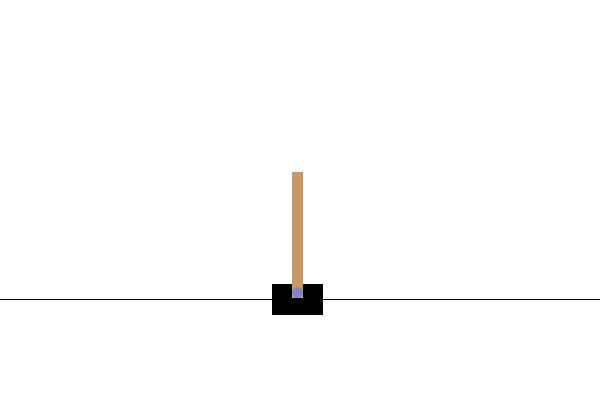

In [80]:
import IPython

IPython.display.Image('./videos/rainbow_dqn_cartpole.gif')

報酬関数は約100であり，棒が倒れようとする方向にカートを移動させていることから，棒が倒れることを防止する制御は学習されていると言える．しかし，約10秒で横方向の位置制限（±2.4）にかかって停止していることから，位置の制御については十分に学習できていない．
シミュレーションステップの最大値が500であることを考えると，報酬を最大化するところまで学習が進んでいるとは言えない．

別途比較用に実施したPID制御による制御では，約3秒で棒を垂直に静止させることに成功しており，機械学習による制御の性能はPID制御と比べて著しく劣っている．


制御のロバスト性を検証するため，倒立振子システムの棒の長さを半分にしてみる．

In [64]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.env.env.env.length *= 0.5
sim_dqn(env, filename="rainbow_dqn_cartpole_short.gif")

--------------- Episode: 0 ---------------
Episodic Reward:  34.0
--------------- Episode: 1 ---------------
Episodic Reward:  36.0
--------------- Episode: 2 ---------------
Episodic Reward:  34.0
--------------- Episode: 3 ---------------
Episodic Reward:  29.0
--------------- Episode: 4 ---------------
Episodic Reward:  29.0
--------------- Episode: 5 ---------------
Episodic Reward:  38.0
--------------- Episode: 6 ---------------
Episodic Reward:  28.0


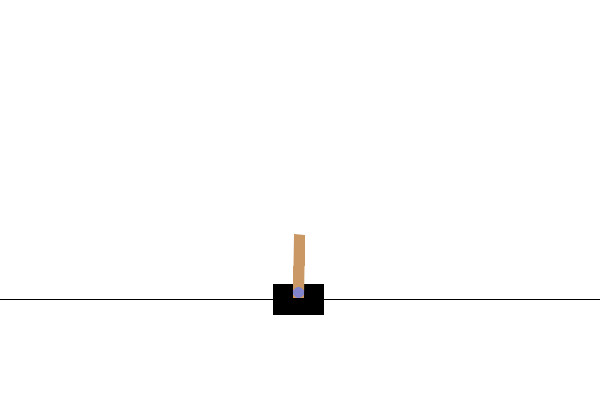

In [81]:
IPython.display.Image('./videos/rainbow_dqn_cartpole_short.gif')

すぐに棒の角度の制限（12度）にひっかかってしまい，終了する．報酬関数も半分程度になってしまう．別途検討したPID制御系では収束時間は少し伸びても，問題なく制御できていたため，強化学習による制御のロバスト性はPID制御よりも劣っていると言える．

# まとめと考察

DQNに対して複数の改良を行った比較的新しい強化学習の手法であるRainbowDQNにより，代表的な不安定システムの倒立振子システムの制御を試みた．棒を倒さないように制御することができてはいたが，数秒で位置の制限範囲内を逸脱することが多く，十分に良好な制御が行えたとは言えなかった．これは，学習が不十分であったことに起因すると思われる．
また，ロバスト性検証のために棒の長さを半分にしたケースでは，棒の制限値にかかり速やかに中断する結果となり，余裕のある制御となっていないことが確認された．
比較対象としたPID制御が数秒で棒を垂直に静止させることができていたことを考えると，制御の性能は劣っていると言える．

原因としては，学習が十分に収束していないことが考えられる．今回は，締切の時間制限や計算機環境が十分に揃えられなかったため，追加の学習や他の方式を試すことはできなかった．機会があれば，実施してみたい．








